In [1]:
#importing relevant libraries
import pandas as pd
import folium, json
import numpy as np 
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr 
from statsmodels.stats.multitest import multipletests

Task 0 - Data cleaning and filtering

In [2]:
# loading weather data 
weather_df = pd.read_csv("./weather.csv")

# Celsius-Kelvin conversion - should be run only ONCE
weather_df["TemperatureAboveGround"] = weather_df["TemperatureAboveGround"] - 273.15

sweden_weather_df = weather_df[weather_df["iso3166-2"].str.startswith("SE")]

# loading corona data
corona_df = pd.read_csv("./se_corona.csv", sep = "\t")
corona_df = corona_df.rename(columns = {"confirmed_addition":"cases"})

#loading Sweden metadata (with additional argument population_density)
with open("./se_metadata.json", "r", encoding="utf-8") as f:
    country_metadata = json.load(f)

In [3]:
#check for missing data
sweden_weather_df.isna().any().any()
corona_df.isna().any().any()

False

In [4]:
# loading Stringency Index and formatting the data frame to our needs

str_df = pd.read_csv("./stringency_index.csv")
str_df = str_df[(str_df["country_name"] == "Sweden")]

str_df = str_df.transpose()
str_df = str_df[3:].dropna() #dropping NA values

str_df = str_df.reset_index()
str_df = str_df.rename(columns={"index": "date", 157: "stringency_index"})

#changing string object to datetime in order to merge columns later
str_df["date"] = pd.to_datetime(str_df["date"])

In [5]:
#adding a column "region" by mapping it to region_code values
region_map = {country_metadata["country_metadata"][i]["covid_region_code"]: country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range (len(country_metadata["country_metadata"]))
}

corona_df ["region"] = corona_df["region_code"].map(region_map)


In [6]:
#adding columns "population" and "cases_per_capita"
population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: country_metadata["country_metadata"][i]["population"] for i in range (len(country_metadata["country_metadata"]))
}

corona_df["population"] = corona_df["region"].map(population_map)
corona_df["cases_per_capita"] = corona_df["cases"]/corona_df["population"] #adding our factor - cases per capita


In [7]:
#first merge - corona and weather
merged_df = corona_df.merge(sweden_weather_df, left_on=["date", "region"], right_on= ["date", "iso3166-2"]) 
merged_df = merged_df.drop("iso3166-2", axis = 1)
merged_df = merged_df.rename(columns = {"region_code":"region_name", "region": "region_code"})

#converting string type to datetime to be able to merge it later in full_df
merged_df["date"] = pd.to_datetime(merged_df["date"]) 

In [8]:
#second merge - merged and stringency index, now have all variables we need to use in one dataframe
full_df = merged_df.merge(str_df, on = "date") 

full_df

,date,region_name,cases,region_code,population,cases_per_capita,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,stringency_index
0,2021-02-18,Blekinge,23,SE-K,159606,0.000144,91.958400,4.169385e+05,2.424771e+06,-0.351750,0.000317,0.572565,4.132720,69.44
1,2021-02-18,Dalarna,78,SE-W,287966,0.000271,83.472412,5.560170e+05,2.327816e+06,-6.324020,0.000902,0.000000,2.789497,69.44
2,2021-02-18,Gotland,3,SE-I,59686,0.000050,76.066474,1.217169e+06,2.449967e+06,-3.398588,0.000011,2.044527,4.697774,69.44
3,2021-02-18,Gävleborg,234,SE-X,287382,0.000814,77.955185,1.722268e+06,2.383899e+06,-5.956068,0.000124,0.000000,2.564518,69.44
4,2021-02-18,Halland,187,SE-N,333848,0.000560,91.276936,6.979065e+03,2.410299e+06,0.282810,0.000647,0.000000,4.960031,69.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7807,2020-02-13,Västernorrland,0,SE-Y,245347,0.000000,83.230208,1.351595e+06,2.320155e+06,-6.075210,0.000045,0.000000,1.497883,5.56
7808,2020-02-13,Västmanland,0,SE-U,275845,0.000000,71.129740,3.511075e+06,2.373874e+06,-0.460946,0.000000,0.000000,2.593358,5.56
7809,2020-02-13,Västra_Götaland,0,SE-O,1725881,0.000000,77.017705,3.841654e+06,2.370478e+06,1.299874,0.000039,0.792579,3.868366,5.56
7810,2020-02-13,Örebro,0,SE-T,304805,0.000000,69.266165,3.927441e+06,2.358019e+06,-0.298819,0.000000,0.000000,3.391266,5.56


Task 1 - Single variable analysis

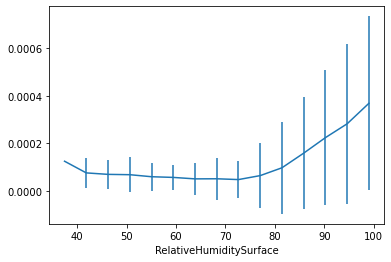

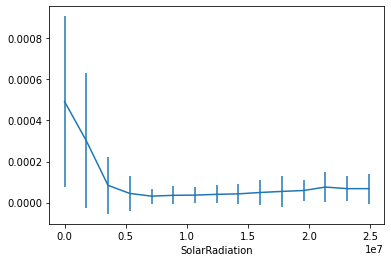

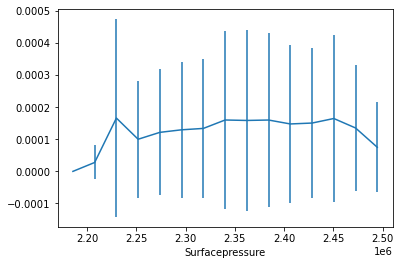

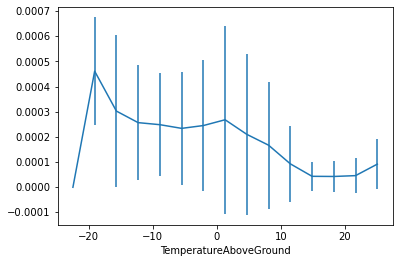

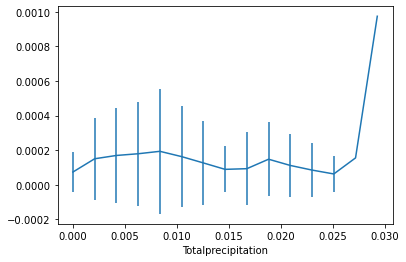

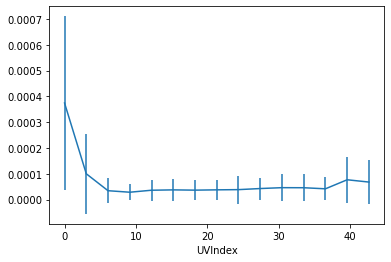

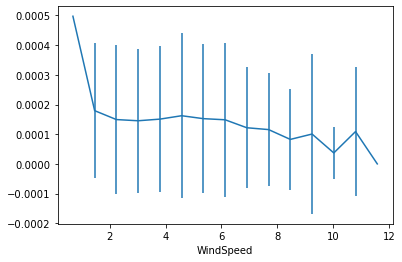

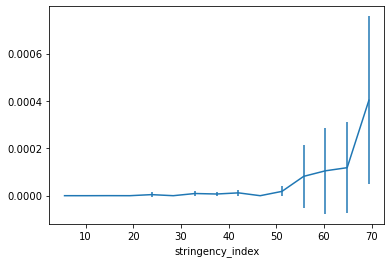

In [9]:
#generating cases_per_capita - weather plots to get an overview of possible correlations
Xs = ["RelativeHumiditySurface", "SolarRadiation", "Surfacepressure", "TemperatureAboveGround", "Totalprecipitation", "UVIndex", "WindSpeed", "stringency_index"]

for var in Xs: #iterating over each weather variable
    mean = []
    standard_deviation = []
    insert = np.linspace(full_df[var].min(), full_df[var].max(), 15) #dividing each plot into 15 bins

    previous_i = -1 #starting from -1 as the bins are right inclusive 
    for i in insert: #iterating over the bins

        #first we isolate a given weather variable's values between <previous i> and <i> 
        #second we calculate mean and standard deviation of cases per capita in the bin
        #third we add it to mean or standard deviation lists to plot it after finishing the for loop

        mean.append(full_df[full_df[var].between(previous_i, i, inclusive = "right")]["cases_per_capita"].mean()) 
        standard_deviation.append(full_df[full_df[var].between(previous_i, i, inclusive = "right")]["cases_per_capita"].std())
        previous_i = i
    
    #temporary data frame for each weather variable
    df_temp = pd.DataFrame({"insert": insert, "mean": mean, "sd": standard_deviation}).fillna(0)

    #plotting
    df_temp.plot('insert', 'mean', yerr='sd', legend = None, xlabel = var)

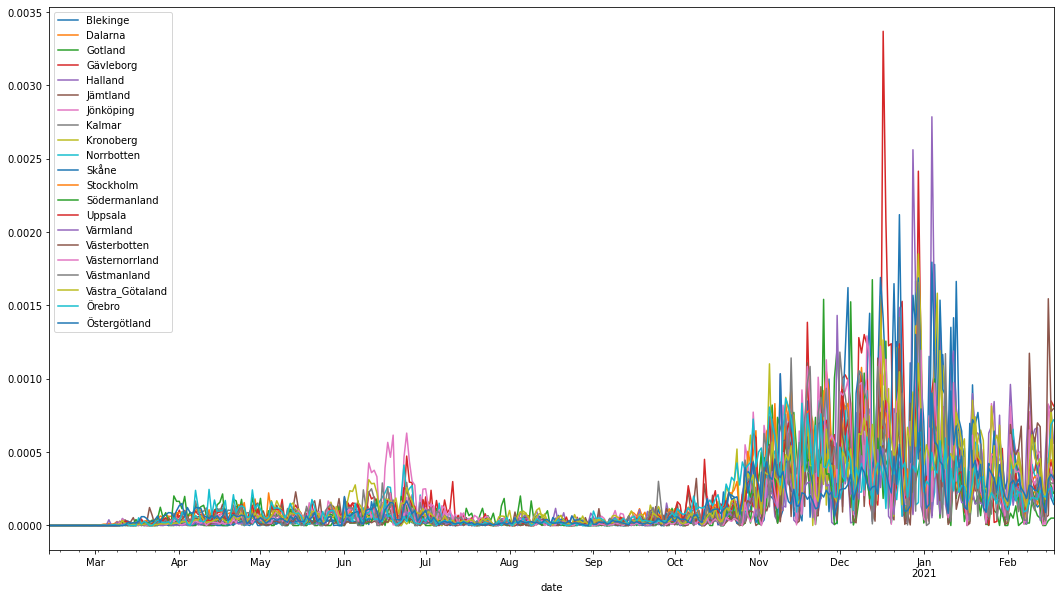

In [10]:
#plotting cases per capita in single variable analysis with daily binning
fig, ax = plt.subplots()

for key, grp in full_df.groupby(['region_name']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='cases_per_capita', label=key, figsize = (18,10))

plt.show()

In [11]:
#grouping by week
#grouping by both frequency and regions to perform weekly sum() of the cases on them later

grouper_weekly = full_df.groupby([pd.Grouper(freq='w', key = "date"), "region_name"]) 

#unstack moves regions to columns for clarity
result_weekly = grouper_weekly["cases_per_capita"].sum().unstack('region_name')

In [12]:
#grouping by month
#grouping by both frequency and regions to perform monthly sum() of the cases on them later
grouper_monthly = full_df.groupby([pd.Grouper(freq='m', key = "date"), "region_name"]) 

#unstack moves regions to columns for clarity
result_monthly = grouper_monthly["cases_per_capita"].sum().unstack('region_name')

In [13]:
#CASES - NOT PER CAPITA (for comparison)

#grouping by month
#grouping by both frequency and regions to perform monthly sum() of the cases on them later
grouper_monthly = full_df.groupby([pd.Grouper(freq='m', key = "date"), "region_name"]) 

#unstack moves regions to columns for clarity
result_monthly_cases = grouper_monthly["cases"].sum().unstack('region_name')

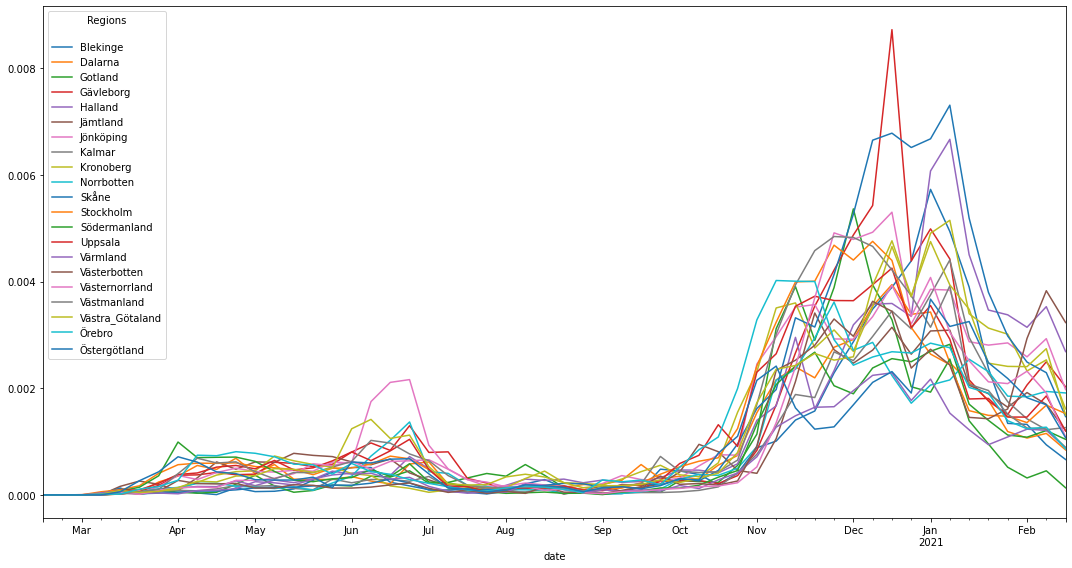

In [14]:
#Generating line chart of cases by week
binning = result_weekly.plot(figsize = (15,8))
binning.legend(title="Regions\n")
plt.tight_layout() #getting rid of returning an object

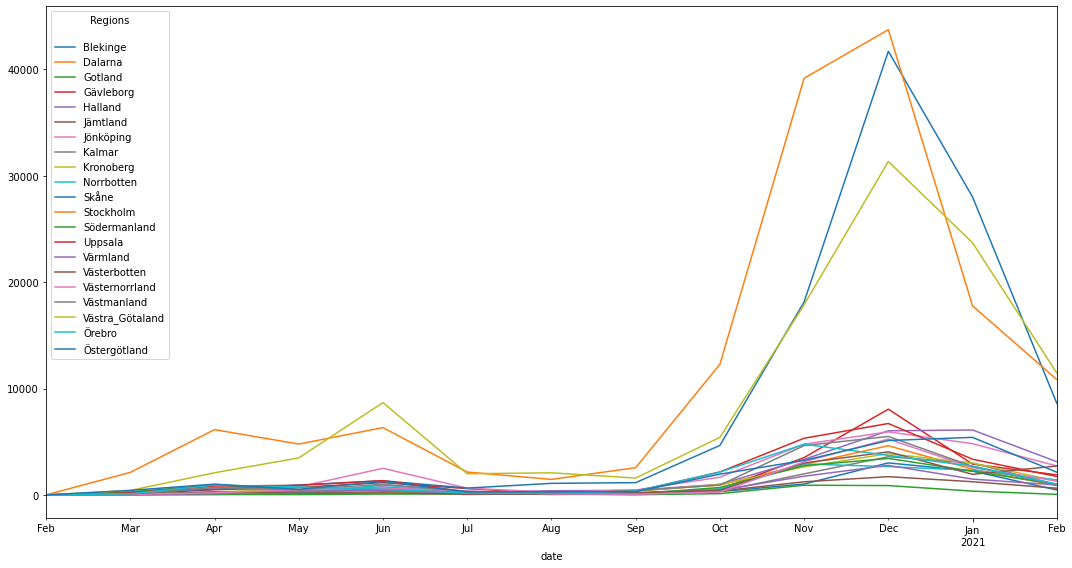

In [15]:
#Generating line chart of cases by month - not cases per capita!
binning = result_monthly_cases.plot(figsize = (15,8))
binning.legend(title="Regions\n")
plt.tight_layout() #getting rid of returning an object

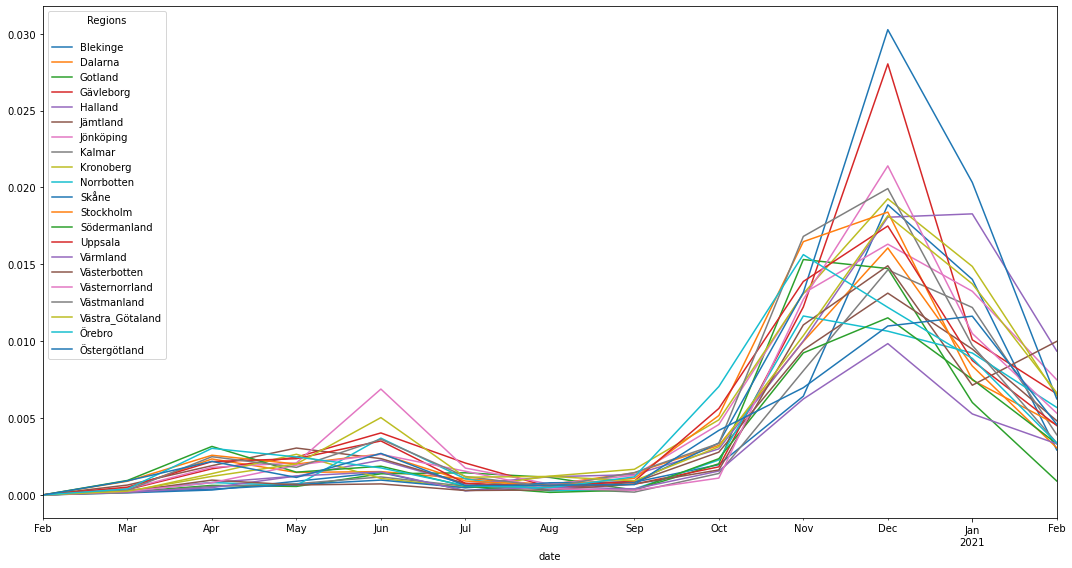

In [16]:
#Generating line chart of cases by month
#After comparing cases and cases_per_capita plots we can see that cases per capita are more balanced, as this is accounting for the population
#This will be explored further in mapping

binning = result_monthly.plot(figsize = (15,8))
binning.legend(title="Regions\n")
plt.tight_layout() #getting rid of returning an object

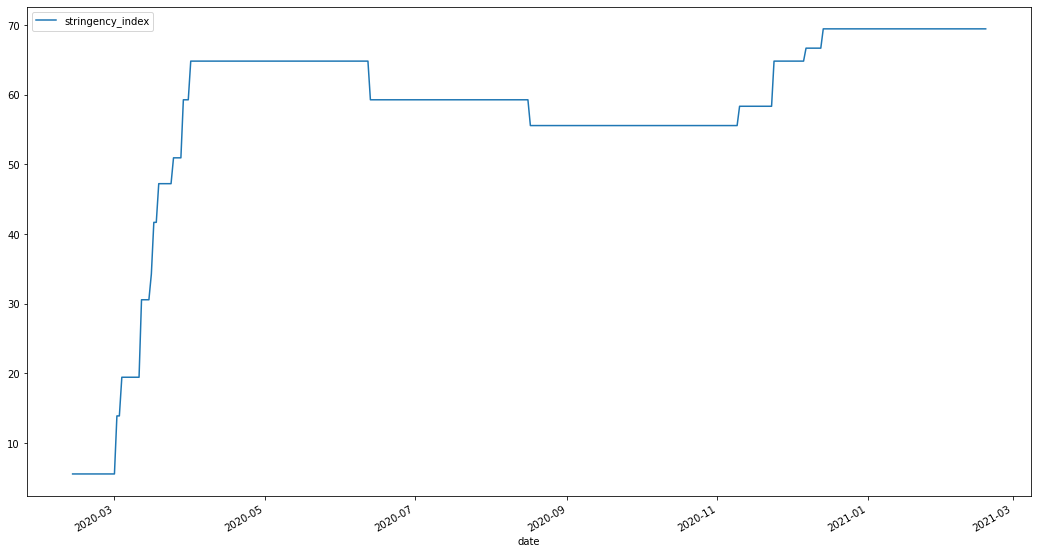

In [17]:
#Generating  Stringency index line chart
ax = full_df.plot(x = "date", y = "stringency_index", figsize = (18,10))

Task 2 - Associations

In [18]:
#removing unwanted columns from the dataframe to be used for regression
weather_variable_subplot_regression = full_df.drop("region_name",axis=1)
weather_variable_subplot_regression = weather_variable_subplot_regression.drop("population", axis=1)


In [19]:
#Multivariate regression without stringency index - linear
Xs3= ["RelativeHumiditySurface", "SolarRadiation", "Surfacepressure", "TemperatureAboveGround", "Totalprecipitation", "UVIndex", "WindSpeed"]
weather_variable_subplot_regression = sm.add_constant(weather_variable_subplot_regression)
Xs3.append("const")

est = sm.OLS(weather_variable_subplot_regression["cases_per_capita"], weather_variable_subplot_regression[Xs3], hasconst = True).fit()

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:       cases_per_capita   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     277.8
Date:                Fri, 04 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:52:27   Log-Likelihood:                 54627.
No. Observations:                7812   AIC:                        -1.092e+05
Df Residuals:                    7804   BIC:                        -1.092e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface  4

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [20]:
#Multivariate regression without stringency index - log
est = sm.OLS(np.log(weather_variable_subplot_regression["cases_per_capita"]+1), weather_variable_subplot_regression[Xs3], hasconst = True).fit()

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:       cases_per_capita   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     277.9
Date:                Fri, 04 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:52:27   Log-Likelihood:                 54631.
No. Observations:                7812   AIC:                        -1.092e+05
Df Residuals:                    7804   BIC:                        -1.092e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface  4

Task 3 - Map generation

In [21]:
#adding a new variable - population_density
density_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: country_metadata["country_metadata"][i]["population_density"] for i in range (len(country_metadata["country_metadata"]))
}

corona_df["population_density"] = corona_df["region"].map(density_map) #adding population_density to the corona_df dataframe

In [22]:
#creating a dataframe for map generation

#For good mapping experience, we have to sum all cases per capita and cases for each region
map_df = full_df.groupby(by = "region_code")["cases_per_capita"].sum().reset_index() 
map_df_cases = full_df.groupby(by = "region_code")["cases"].sum().reset_index() 

#region_code is used here because geoJSON has region_codes in the raw data, not region_names

#adding population and population desity columns to the mapping dataframe
#copying cases from a temporary dataframe
map_df["cases"] = map_df_cases["cases"]
map_df["population_density"] = map_df["region_code"].map(density_map)
map_df["population"] = full_df["population"]

map_df


,region_code,cases_per_capita,cases,population_density,population
0,SE-AB,0.062821,149331,360.0,159606
1,SE-AC,0.048595,13205,4.9,287966
2,SE-BD,0.046543,11640,2.6,59686
3,SE-C,0.061004,23408,45.0,287382
4,SE-D,0.042475,12638,52.0,333848
5,SE-E,0.047236,21988,43.0,130810
6,SE-F,0.069632,25318,34.0,363599
7,SE-G,0.067241,13547,23.0,245446
8,SE-H,0.044006,10801,22.0,201469
9,SE-I,0.044634,2664,19.0,250093


In [23]:
#MAPPING - all variables are in linear scale, making them fit for comparison

#1) CASES PER CAPITA

map_cases_capita = folium.Map(location = [63,15], zoom_start = 4, tiles = "OpenStreetMap")

folium.Choropleth(
    geo_data = "./se.geojson",
    name = "cases",
    data = map_df,
    columns=["region_code", "cases_per_capita"],
    key_on = "feature.properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name="Cases per Capita"
).add_to(map_cases_capita)

map_cases_capita

In [24]:
#2) POPULATION DENSITY 

#new dataset - people per square kilometer. Added to raw metadata of Sweden manually

map_density = folium.Map(location = [63,15], zoom_start = 4, tiles = "OpenStreetMap")

folium.Choropleth(
    geo_data = "./se.geojson",
    name = "density",
    data = map_df,
    columns=["region_code", "population_density"],
    key_on = "feature.properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name="Population Density"
).add_to(map_density)

map_density

In [25]:
#3) CASES

map_cases = folium.Map(location = [63,15], zoom_start = 4, tiles = "OpenStreetMap")

folium.Choropleth(
    geo_data = "./se.geojson",
    name = "cases",
    data = map_df,
    columns=["region_code", "cases"],
    key_on = "feature.properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name="Cases"
).add_to(map_cases)

map_cases

In [26]:
#4) POPULATION

map_population = folium.Map(location = [63,15], zoom_start = 4, tiles = "OpenStreetMap")

folium.Choropleth(
    geo_data = "./se.geojson",
    name = "cases",
    data = map_df,
    columns=["region_code", "population"],
    key_on = "feature.properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name="Population"
).add_to(map_population)

map_population

Task 4 - Open question

In [27]:
# defining weather variables + stringency index for analysis
Xs= ["RelativeHumiditySurface", "SolarRadiation", "Surfacepressure", "TemperatureAboveGround", "Totalprecipitation", "UVIndex", "WindSpeed", "stringency_index"]
weather_variable_subplot_regression = sm.add_constant(weather_variable_subplot_regression)
Xs.append("const")


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [28]:
# Multivariate regression with stringency index - linear
weather_variable_subplot_regression["stringency_index"] = weather_variable_subplot_regression["stringency_index"].astype(int)

est = sm.OLS(weather_variable_subplot_regression["cases_per_capita"], weather_variable_subplot_regression[Xs], hasconst = True).fit()

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:       cases_per_capita   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     451.9
Date:                Fri, 04 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:52:28   Log-Likelihood:                 55245.
No. Observations:                7812   AIC:                        -1.105e+05
Df Residuals:                    7803   BIC:                        -1.104e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface  4

In [29]:
## Multivariate regression with stringency index - log
est = sm.OLS(np.log(weather_variable_subplot_regression["cases_per_capita"]+1), weather_variable_subplot_regression[Xs], hasconst = True).fit()

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:       cases_per_capita   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     452.1
Date:                Fri, 04 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:52:28   Log-Likelihood:                 55250.
No. Observations:                7812   AIC:                        -1.105e+05
Df Residuals:                    7803   BIC:                        -1.104e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface  4